# Analyzing Two Photon Data

On the previous page, we introduced how to retrieve specific experiments from the Allen Institute SDK's Brain Observatory. Here we'll introduce how researchers analyze this data, from processing single cell activity to understanding tuning curves.

## Setup
We need a variety of standard Python packages in addition to two different `allensdk` toolboxes. If you have not yet installed the `allensdk`, run the cell below. Otherwise, you can skip to the cell that imports our toolboxes.

In [1]:
# This will ensure that the AllenSDK is installed.
# If not, it will install it for you.
try:
    import allensdk
    print('allensdk already installed.')
except ImportError as e:
    !pip install allensdk

allensdk already installed.


In [4]:
# Import toolboxes
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

print('Packages imported.')

Packages imported.


As a final setup step, we need to once again create an instance of the Brain Observatory Cache as an object, `boc`.

In [5]:
# Create an instance of the Brain Observatory cache
boc = BrainObservatoryCache(manifest_file='manifest.json')

## Download & inspect the natural scenes imaging session
First, we'll look at the session where the mouse viewed natural scenes. Below, we'll designate an experiment ID (the same one we worked with in the previous section), designate that we're interested in only the natural scenes experiments, and grab the container for that experiment.

**Note**: The cell below downloads some data, and make take a minute or so to run. It is important that you do not interrupt the download of the data or else the file will become corrupted and you will have to delete it and try again. 

In [ ]:
# Assign previous container ID
exp_container_id = 627823571

# Get experiment container for our id and stimuli of interest
expt_cont = boc.get_ophys_experiments(experiment_container_ids = [exp_container_id],stimuli = ['natural_scenes'])

# Get the experiment data using the session id
session_id = expt_cont[0]['id']
data = boc.get_ophys_experiment_data(session_id)

print('Data acquired.')

Let's take a quick look at the data you just acquired. We'll create a **maximum projection image** of the data, so that we can see the cells in our field of view. If we just looked at one snapshot of the raw imaging data, the cells would look dim -- they only become bright when they're actively firing. A maximum projection image shows us the maximum brightness for each pixel, across the entire experiment.

Below, we are using the `get_max_projection()` method on our data, and then using the `imshow()` method in order to see our projection.

**Note**: The weird text for the ylabel is called "TeX" markup, in order to get the greek symbol *mu* ($\mu$). See documentation <a href="https://matplotlib.org/tutorials/text/mathtext.html">here</a>.

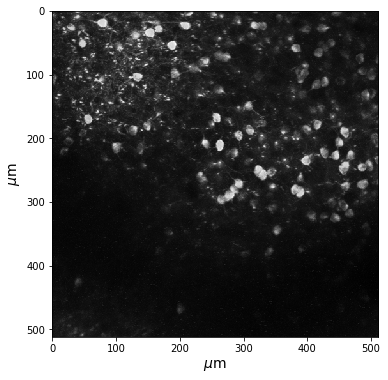

In [7]:
# Get the maximum projection (a numpy array) of our data
max_projection = data.get_max_projection()

# Create a new figure
fig = plt.figure(figsize=(6,6))

# Use imshow to visualize our numpy array
plt.imshow(max_projection, cmap='gray')

# Add labels for microns; weird syntax below is to get the micro sign
plt.ylabel(r'$\mu$m',fontsize=14)
plt.xlabel(r'$\mu$m',fontsize=14)
plt.show()

## Converting Calcium Imaging into Spikes 

Now we'll plot the data of each of our cells (from the field of view above) across time. Each line shows the change in fluorescence over baseline ($\Delta$)F/F) of the individual cells. When there are sharp increases, that's when the cells are responding.

In the example below, the we will plot the first 10 cells from our data. the `get_dff_traces()` method returns the timestamps (in seconds) and deltaF/F.

Below, we've also added a line in our loop that offsets each cell by a predetermined amount so that we can see individual calcium traces. Each line is a different neuron, and the small blips in the data are calcium-mediated changes in fluorescence.

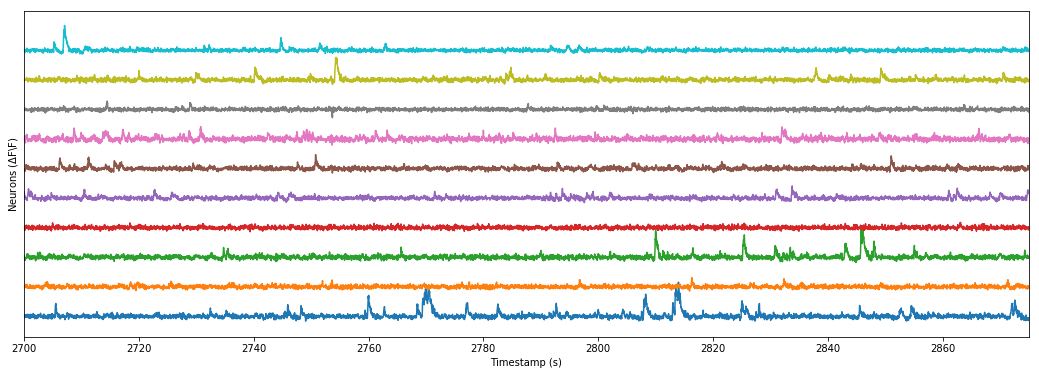

In [8]:
# Assign timestamps and deltaF/F
ts, dff = data.get_dff_traces()

# Set up a figure
fig = plt.figure(figsize=(18,6))

# Loop through to add an offset on the y-axis
offset = 0
for cell in range(2,12):
    plt.plot(ts, dff[cell]+offset)
    offset+=2
    
plt.xlabel('Timestamp (s)')
plt.ylabel('Neurons ($\Delta$F\F)')
plt.yticks([])
plt.xlim([2700,2875])
plt.show()

## Look at the response of your cells to natural scenes
Hmm, there are clearly some responses above, but it's tough to see whether this corresponds to different behaviors or visual stimuli with just the raw fluorescence traces.

Let's see how these cells actually responded to different types of images. To do so, we'll need to use the `get_cell_specimens()` method on our `boc`, giving it the name of the experiment container ID.

The dataframe that this creates will have a lot more information about what the cells in our experiment prefer. Each row is a different cell, each with its own preferences and response patterns.

In [11]:
# Get the cell specimens information for this session
cell_specimens = boc.get_cell_specimens(experiment_container_ids=[exp_container_id])
cell_specimens_df = pd.DataFrame(cell_specimens)
cell_specimens_df.head()

,all_stim,area,cell_specimen_id,donor_full_genotype,dsi_dg,experiment_container_id,failed_experiment_container,g_dsi_dg,g_osi_dg,g_osi_sg,...,specimen_id,tfdi_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
0,False,VISp,669921450,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,0.735301,657016265,False,0.215625,0.209022,NaN,...,646855414,0.322698,NaN,NaN,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
1,False,VISp,669921456,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,NaN,657016265,False,NaN,NaN,0.421526,...,646855414,NaN,0.29934,0.33260,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
2,False,VISp,669921462,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,NaN,657016265,False,NaN,NaN,NaN,...,646855414,NaN,NaN,NaN,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
3,True,VISp,669921489,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,0.928895,657016265,False,0.928895,1.000000,0.357914,...,646855414,0.320423,0.33260,0.23282,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)
4,False,VISp,669921503,Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,0.739761,657016265,False,0.543225,0.519046,0.656651,...,646855414,0.286877,0.29934,0.33260,265180449,Tlx3-Cre_PL56,None,None,528393470,Ai148(TIT2L-GC6f-ICL-tTA2)


Let's create a bar graph of preferred images in our dataset. The `p_ns` column contains the pvalue that corresponds to whether a cell *significantly* prefered an image more than the rest. We will use this column to subset our `cell_specimens_df` dataframe to only contains cells that have a p value less than 0.05. 

The `pref_image_ns` column contains the image IDs of the stimulus being presented. We can create our histogram from this column to see how many cells responded to these statistically significant stimuli. 

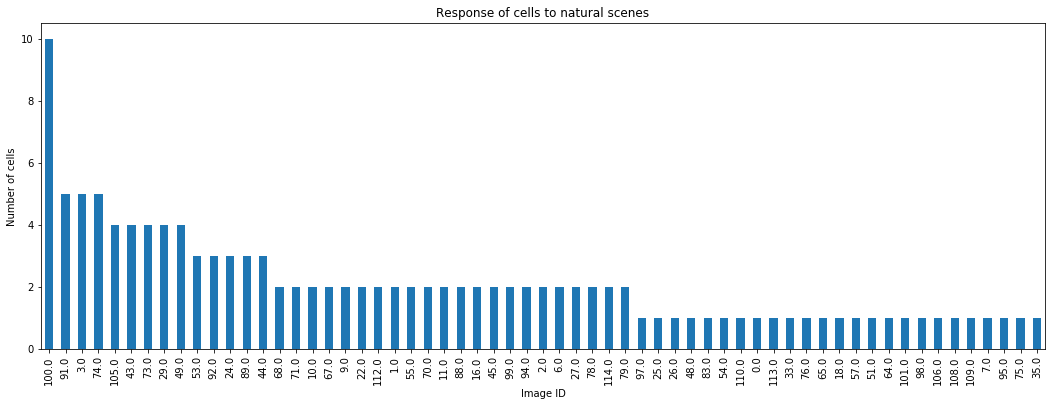

In [14]:
# Subset dataframe to contain significantly preferred images 
sig_cells = cell_specimens_df[cell_specimens_df['p_ns'] < 0.05]

# Assign our image ids for significantly preferred images
pref_images = sig_cells['pref_image_ns']

# Set up our figure 
fig = plt.figure(figsize = (18,6))

# Plot our bar graph
pref_counts = pref_images.value_counts()
pref_counts.plot(kind='bar')
plt.title('Response of cells to natural scenes')
plt.ylabel('Number of cells')
plt.xlabel('Image ID')
plt.show()

In order to actually see what this stimulus are, first, we'll organize the stimulus table. This tells us which stimulus was played on each trial. This data set has 118 different scenes, and each scene is presented 50 times. Images of the scenes can be found [here](http://observatory.brain-map.org/visualcoding/stimulus/natural_scenes).

Below, we'll show the top five images for cells in this field of view. Do they have anything in common, either visually or conceptually?

*Note*: Not every experiment contains the data for the natural scenes experiment. If you change the experiment ID above and try the next cell, you may receive an error. You can use `data.list_stimuli()` to see all of the stimuli available within your experiment.

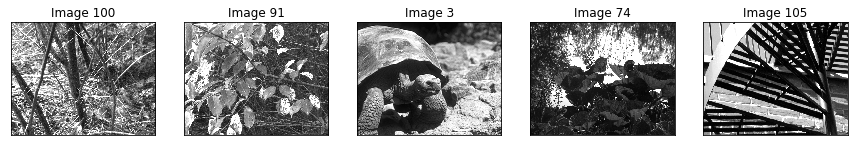

In [15]:
# Get the natural scene information
natural_scene_table = data.get_stimulus_table('natural_scenes')
natural_scene_template = data.get_stimulus_template('natural_scenes')
sceneIDs = np.unique(natural_scene_table.frame)

# Set up our figure
fig,ax = plt.subplots(1,5,figsize=(15,6))

for image_ID in range(5): # Show the first 5 images
    
    image_id = int(pref_counts.index[image_ID]) # Get the image ID

    # Use imshow to visualize our numpy array
    ax[image_ID].imshow(natural_scene_template[image_id,:,:],cmap='gray')
    ax[image_ID].set_xticks([])
    ax[image_ID].set_yticks([])
    ax[image_ID].set_title('Image ' + str(image_id))
    
plt.show()

## Examine the direction selectivity of your cell
Sometimes, the function of a cell is not particularly clear from natural stimuli. Those stimuli have a lot of information in them, and it might be hard to tell what a cell is actually responding to. Instead, we can use simple drifting gratings to look at one straightforward property of a cell: <b>does it respond to specific directions of movement?</b></br> To do so, we'll examine the **drifting gratings** experiments.

We will now show how to plot a heatmap of a cell's response organized by orientation and temporal frequency. We will be using one of the three cells from the dataframe above which showed direction selectivity from the significantly preferred images.

Below, we'll use the same experiment container but a different stimulus to create a separate experiment container, `expt_cont_dg`.

In [16]:
# Get experiment container for our id and stimuli of interest
expt_cont_dg = boc.get_ophys_experiments(
                        experiment_container_ids = [exp_container_id],
                        stimuli = ['drifting_gratings'] )

# Get the experiment data using the sesion id
session_id = expt_cont_dg[0]['id']
data_dg = boc.get_ophys_experiment_data(session_id)

print('Data acquired.')

Data acquired.


Our first step is to create an instance of our DriftingGratings object. The DriftingGratings class requires an NWB data set as an input. 

The peak property of the DriftingGratings object is a Pandas DataFrame of peak conditions (direction and temporal frequency) as well as computed response metrics.

** EXPLAIN THIS **

In [17]:
from allensdk.brain_observatory.drifting_gratings import DriftingGratings

# Create my DriftingGratings Object 
dg = DriftingGratings(data_dg)

# Return dataframe of peak conditions
dg_df = dg.peak
dg_df.head()

/Users/ashley/anaconda3/lib/python3.7/site-packages/allensdk/brain_observatory/drifting_gratings.py:191: RuntimeWarning: invalid value encountered in double_scalars
  peak.cv_os_dg.iloc[nc] = np.abs(CV_top_os.sum())/tuning.sum()
/Users/ashley/anaconda3/lib/python3.7/site-packages/allensdk/brain_observatory/drifting_gratings.py:192: RuntimeWarning: invalid value encountered in double_scalars
  peak.cv_ds_dg.iloc[nc] = np.abs(CV_top_ds.sum())/tuning.sum()


,ori_dg,tf_dg,reliability_dg,osi_dg,dsi_dg,peak_dff_dg,ptest_dg,p_run_dg,run_modulation_dg,cv_os_dg,cv_ds_dg,tf_index_dg,cell_specimen_id
0,3,1,0.051995,0.827356,0.553485,5.331719,0.0,NaN,NaN,0.626177,0.537493,0.43855,669922218
1,4,1,0.063828,2.023457,0.847934,5.105556,0.0,NaN,NaN,1.0,0.847934,0.402397,669921865
2,0,4,-0.012967,1.193879,0.784814,2.540356,0.0,NaN,NaN,0.848984,0.777981,0.318317,669925542
3,1,3,0.040306,-1.615926,0.360709,1.113922,0.0,NaN,NaN,1.0,0.360709,0.178264,669925565
4,2,5,-0.002141,0.749414,0.50695,2.163388,0.0,NaN,NaN,0.543365,0.121033,0.418183,669925609


Next, we'll select a cell from our table by `cell_specimen_id`.

If there is a specific cell you want to analyze, you can use the `get_cell_specimen_indices()` method to locate the index of your cell of interest. [ UNCLEAR WHY THIS IS NECESSARY ]

Below, we'll simply grab the first cell_specimen_id in our table.

In [20]:
# Select specimen ID from first row
specimen_id = dg_df['cell_specimen_id'][0]
cell_loc = data_dg.get_cell_specimen_indices([specimen_id])[0]

print('Specimen ID:', specimen_id)

Specimen ID: 669922218


The `response` attribute returns the mean responses to each stimulus condition (i.e. orientation, frequency). Below, we'll use `plt.imshow()` to plot the responsesa cross orientation and frequency, skipping the blank sweep column (0).

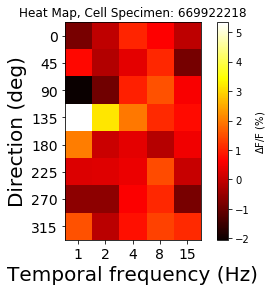

In [21]:
# Plot our data, skiping the blank sweep column (0) of the temporal frequency dimension
plt.imshow(dg.response[:,1:,cell_loc,0], cmap='hot', interpolation='none')
plt.title('Heat Map, Cell Specimen: ' + str(specimen_id))
plt.xticks(range(5), dg.tfvals[1:])
plt.yticks(range(8), dg.orivals)
plt.xlabel("Temporal frequency (Hz)", fontsize=20)
plt.ylabel("Direction (deg)", fontsize=20)
plt.tick_params(labelsize=14)
cbar= plt.colorbar()
cbar.set_label("$\Delta$F/F (%)")

The preferred directions temporal frequency are stored within `ori_dg` and `tf_dg` in are table above and can be indexed through `dg.orivals` and `tf.tfvals` respectively. 

For more explanation on the available pre-computed metrics, please see <a href = 'https://alleninstitute.github.io/AllenSDK/_static/examples/nb/brain_observatory_analysis.html#Drifting-Gratings'> here</a>. 

In [22]:
pref_ori = dg.orivals[dg.peak.ori_dg[cell_loc]]
pref_tf = dg.tfvals[dg.peak.tf_dg[cell_loc]]
print("Preferred direction:", pref_ori)
print("Preferred temporal frequency:", pref_tf)

Preferred direction: 135
Preferred temporal frequency: 1


[ CLOSING THOUGHTS ON WHAT ELSE YOU CAN DO WITH THIS DATA! ]

## Additional Resources 

[ INTEGRATE THESE THROUGHOUT! ] 

- Click on the link<a href = 'https://alleninstitute.github.io/AllenSDK/allensdk.core.brain_observatory_cache.html'> here </a> for the original documentation to the BrainObservatoryCache object. 
- Click on the link<a href = 'https://alleninstitute.github.io/AllenSDK/allensdk.core.brain_observatory_nwb_data_set.html'> here </a> for the original documentation to the methods used in the fluorescence imaging and natural scenes section. 
- Click on the link<a href = 'https://allensdk.readthedocs.io/en/latest/allensdk.brain_observatory.drifting_gratings.html'> here </a> for the original documentation to the methods used in the drifting gratings section. 